In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.special import digamma 

In [16]:
def defineKnot(X,K=14):
    upper = max(X)
    lower = min(X)
    out = np.linspace(start=lower,stop=upper,num=K+2)[1:K+1]
    return(out)

In [17]:
def b(u,tau,sd):
    lst = []
    lst.append(u)
    for i in tau:
        lst.append(abs((u-i)/sd)**3)
    out = np.array(lst)
    return(out)

In [18]:
def mkToy(n=800,tau = 0.5):
    x = np.random.uniform(size = n)
    e = np.random.normal(0,np.sqrt(0.5), size= n)
    y = 3*np.exp(-30*(x-0.2)**2) + np.exp(-50*(x-0.7)**2) + e
    #out = np.column_stack([x,y])
    return(x,y)

In [22]:
x,yoigin = mkToy()
y = yoigin - yoigin.mean()

In [61]:
sd = np.std(x)
knot = defineKnot(x)
d_x = b(x,knot,sd).T
fitted  = d_x.dot(np.linalg.inv(d_x.T.dot(d_x))).dot(d_x.T).dot(y)

In [220]:
W = d_x
n,p = W.shape
beta = np.linalg.inv(d_x.T.dot(d_x)).dot(d_x.T).dot(y)
pi = 0.5
nu = np.repeat(1,p)
sigma2 =1
api = 1
bpi = 1
Lam2 = 1
alam =1
blam =1

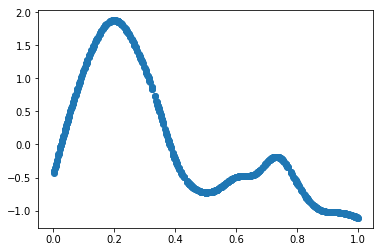

In [221]:
plt.plot(x,fitted,'o')

In [222]:
#sample beta
def sampBeta(W,beta,nu,pi):
    L = np.zeros(p)
    De = np.zeros(p)
    Nu = np.zeros(p)
    for j in range(p):
        De[j] = W[:,j].T.dot(W[:,j]) + 1/nu[j]
        #Nu[j] = (y -np.delete(W,j,1).dot(np.delete(beta,j,0))).T.dot(W[:,j])
        Nu[j] = (y).T.dot(W[:,j])

    for j in range(p):
        L[j] = pi/(pi+ np.exp((Nu[j]**2)/(2*De[j]*sigma2))*(1-pi)*((1+nu[j])*W[:,j].dot(W[:,j]))**(-1/2))

    Beta = np.zeros(p)

    for j in range(p):
        cutoff = np.random.uniform()
        if cutoff > L[j]:
            Beta[j]=np.random.normal(Nu[j]/De[j],np.sqrt(sigma2/De[j]))
        else:
            Beta[j]=0
    return(Beta)

In [223]:
# sample pi
def samplepi(Beta):
    nzero = (Beta==0).sum()
    Pi = np.random.beta(api + nzero,bpi+ p -nzero)
    return(Pi)

In [224]:
def samplesigma2(Beta,Nu):
    nzero = (Beta==0).sum()
    N = n + p -nzero -1
    Dv = np.diag(1/Nu)
    salpha = N/2
    sbeta = 0.5*(y-W.dot(Beta)).dot(y-W.dot(Beta))+Beta.T.dot(Dv).dot(Beta)
    ss = np.random.gamma(salpha,1/sbeta)
    Sigma2 = 1/ss
    return(Sigma2)

In [225]:
def sampleNu(Beta,Lam2,Sigam2):
    V = np.zeros(p)
    for j in range(p):
        if Beta[j]==0:
            V[j] = np.random.gamma(1,Lam2/2)
        else :
            V[j] = np.random.normal(np.sqrt(Lam2*Sigma2/(Beta[j])**2),np.sqrt(Lam2))
    out = 1/V
    return(out)

In [226]:
def samlpelam2(Nu,Beta):
    nzero = (Beta==0).sum()
    lalpha = p + alam
    lbeta = nzero/2 + blam
    out = np.random.gamma(lalpha,1/lbeta)
    return(out)

In [227]:
#init
Beta = sampBeta(W,beta,nu,pi)
Pi = samplepi(Beta)
Sigma2 = samplesigma2(Beta,Nu)
Nu = sampleNu(Beta,Lam2,Sigma2)
Lam2 = samlpelam2(Nu,Beta)

param = [Beta,Pi,Sigma2,Nu,Lam2]
betalst = [Beta]

In [242]:
for k in range(100000):
    Beta = sampBeta(W,Beta,Nu,Pi)
    Pi = samplepi(Beta)
    Sigma2 = samplesigma2(Beta,Nu)
    Nu = sampleNu(Beta,Lam2,Sigma2)
    Lam2 = samlpelam2(Nu,Beta)

    param.append([Beta,Pi,Sigma2,Nu,Lam2])
    betalst.append(Beta)

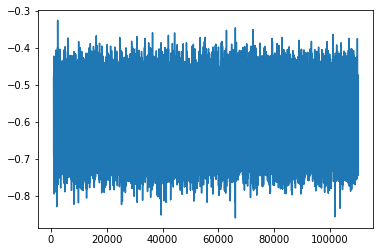

In [243]:
plt.plot(pd.DataFrame(betalst)[0][1000:])

In [244]:
def acf(sampl,lag =40):
    sampl = np.array(sampl)
    base = sampl.dot(sampl)/len(sampl)
    acr = [1]
    for t in range(1,lag):
        acr.append((sampl[t:].dot(sampl[:-t])/(len(sampl)-t))/base)
    x = list(range(lag))
    plt.bar(x,acr,color='gray')
    plt.title('Autocorrelation plot')
    plt.hlines(0.05,xmin=-0.5 ,xmax=lag,colors='r',linestyles='dashed')
    plt.hlines(-0.05,xmin=-0.5 ,xmax=lag,colors='r',linestyles='dashed')
    #plt.show()

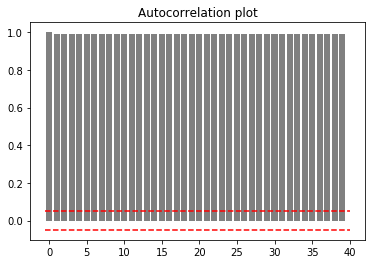

In [245]:
acf(pd.DataFrame(betalst)[0][10000:])

In [252]:
medebetalst = []
for j in range(p):
    medebetalst.append(pd.DataFrame(betalst)[j][50000])

In [257]:
df = pd.DataFrame(betalst)
df.iloc[0,:]

0    -0.715411
1    -0.041065
2    -0.050388
3    -0.064643
4    -0.087643
5    -0.115931
6    -0.138115
7    -0.089984
8     0.000000
9     0.120704
10    0.097411
11    0.086790
12    0.065001
13    0.051762
14    0.038259
Name: 0, dtype: float64

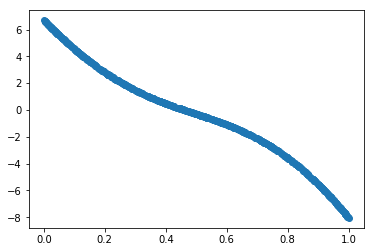

In [259]:
medebetalst = df.iloc[100,:]
plt.plot(x,d_x.dot(medebetalst),'o')

In [240]:
beta

array([  1.26907949,  -1.46012801,  -2.47185509,   8.60918576,
        -5.79540753,   9.16373308, -11.26882131,   2.98640839,
        -5.63469397,  13.84937719, -21.52735953,  23.3706817 ,
        -8.37179514,  -5.62781926,   3.80034775])

In [241]:
medebetalst

[-0.590310694494414,
 -0.040064685504771456,
 -0.05148803704592767,
 -0.06697583529527616,
 -0.08801644439348004,
 -0.11463874826571932,
 -0.13465985931527202,
 -0.08811216169045738,
 0.03965449716291677,
 0.10917010283228461,
 0.10410308996330381,
 0.08366778064640891,
 0.06474214964691007,
 0.05014969342107498,
 0.03913730890048891]

(array([7.0000e+01, 1.7780e+03, 1.2623e+04, 3.4030e+04, 3.6906e+04,
        1.8714e+04, 4.9810e+03, 8.0100e+02, 8.7000e+01, 5.0000e+00]),
 array([ 7.52145596,  8.19198266,  8.86250937,  9.53303607, 10.20356277,
        10.87408948, 11.54461618, 12.21514289, 12.88566959, 13.55619629,
        14.226723  ]),
 <a list of 10 Patch objects>)

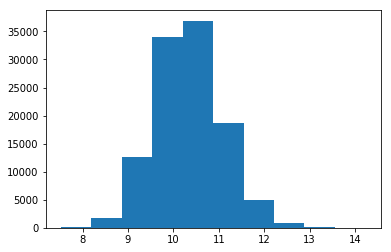

In [271]:
plt.hist(pd.DataFrame(param[10:])[2])

In [265]:
list(map(lambda x : x[2],param))

TypeError: 'float' object is not subscriptable

In [266]:
param[]

array([-0.71541139, -0.04106506, -0.05038833, -0.06464299, -0.08764332,
       -0.11593132, -0.13811475, -0.08998379,  0.        ,  0.12070426,
        0.09741121,  0.08679041,  0.0650007 ,  0.05176241,  0.03825858])

In [268]:
param[10]

[array([-0.618074  , -0.03538881, -0.05582441, -0.06084002, -0.07473919,
        -0.11785221, -0.13805748, -0.08545485,  0.05277963,  0.09879106,
         0.1027466 ,  0.08122603,  0.06045805,  0.03975094,  0.0423797 ]),
 0.0019989003256624845,
 9.265422830169321,
 array([0.07252363, 0.00335548, 0.00533142, 0.0057443 , 0.00744978,
        0.01122205, 0.01232287, 0.00833653, 0.00518264, 0.00915454,
        0.01005197, 0.00814629, 0.00594359, 0.00384997, 0.00410931]),
 13.828908885583639]